In [1]:
%pip install tf_keras_vis tflite-support-nightly

ERROR: Could not find a version that satisfies the requirement tflite-support-nightly (from versions: none)
ERROR: No matching distribution found for tflite-support-nightly
Note: you may need to restart the kernel to use updated packages.


# Create your dataset

1) Choose which classes you would like to add.

2) Create a dataset with your own photos

3) Separate your dataset into train and test subsets.

In [2]:
NB_CLASSES = 7

In [3]:
import os
import pandas as pd
import numpy as np
from glob import glob

def create_dataframe_from_directories(path):
    data = []

    for label_dir in os.listdir(path):
        if os.path.isfile(label_dir):
            continue

        label_path_path = os.path.join(path, label_dir)
        for file in os.listdir(label_path_path):
            data.append([os.path.join(label_path_path, file), label_dir])
        
    return pd.DataFrame(data, columns = ["path", "label"])

In [4]:
train_df = create_dataframe_from_directories("dataset_train")
test_df = create_dataframe_from_directories("dataset_test")

In [5]:
LABEL_NAMES = pd.unique(train_df['label'])
LABEL_NAMES

array(['football', 'pingpong', 'basketball', 'volleyball', 'spikeball',
       'rugby', 'tennis'], dtype=object)

## Some images of your dataset

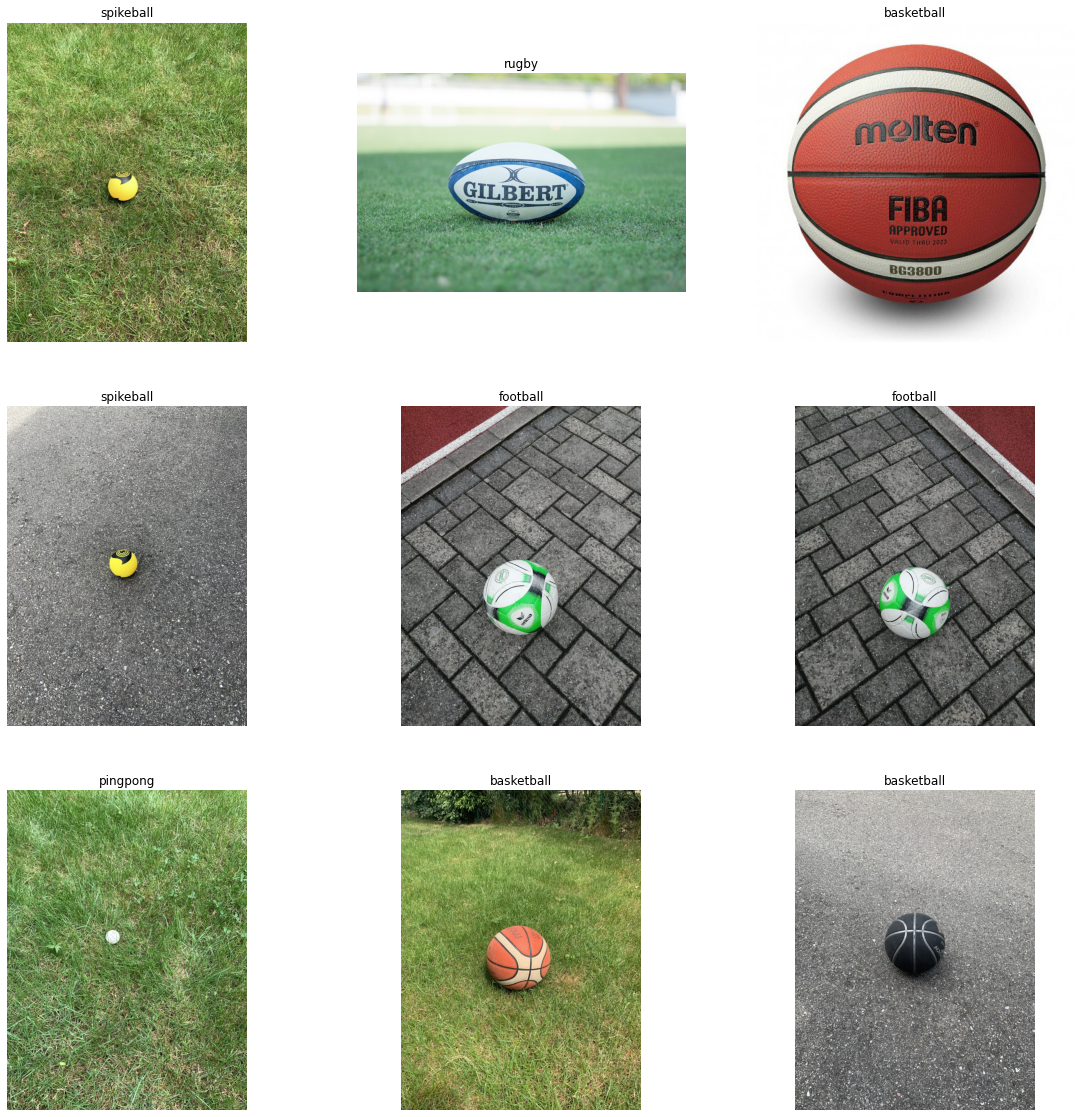

In [6]:
import matplotlib.pyplot as plt
import PIL
import PIL.Image
 
plt.figure(figsize=(20, 20))

i = 0
for _, rowdata in train_df.sample(frac=1).head(9).iterrows():
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(PIL.Image.open(rowdata.path))
    plt.title(rowdata.label)
    plt.axis("off")
    i += 1

# Explore your dataset

In [7]:
def create_histogram(train, test):
    df1 = train.groupby('label').count()
    df2 = test.groupby('label').count()
    df = pd.merge(df1, df2, on='label')
    
    return df.plot.bar(title="Nombre d'images par classe",
                       xlabel='Classe',
                       ylabel="Nombre d'images").legend(["Train", "Test"])

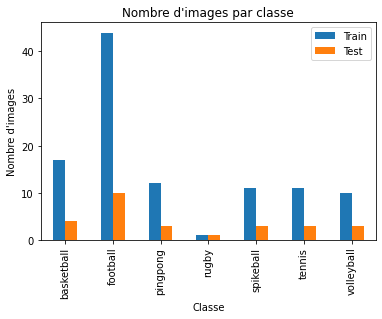

In [8]:
create_histogram(train_df, test_df)

# Preprocessing steps

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Resizing, Rescaling, RandomFlip, RandomRotation, RandomContrast, RandomZoom
)

'''
RandomFlip(mode="horizontal_and_vertical", seed=None),
RandomRotation(
    factor=(-1, 1),
    fill_mode='reflect',
    interpolation='bilinear',
    seed=None,
    fill_value=0.0
),
'''

from tensorflow.keras import Sequential

IMG_HEIGHT = 224
IMG_WIDTH = 224

image_preprocesses = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH, crop_to_aspect_ratio=True),
    Rescaling(1. / 255)
])

image_augmentations = Sequential([
    RandomFlip(seed=None),
    RandomContrast(factor=[0.3, 0.7], seed=None),
    RandomZoom(height_factor=(0.0, -0.3), width_factor=(0.0, -0.3), fill_mode="reflect", interpolation="bilinear", seed=None),  
    RandomRotation(0.4),
    # TODO: choose some image augmentations layers
    # see which keras layers you can use
    # The kind of layers you will want to use starts with "Random".
    # See the following page for more information on data augmentation :
    # https://www.tensorflow.org/tutorials/images/data_augmentation
])

def open_images(paths):
    return np.stack([
        open_image(path) for path in paths
    ])

def open_image(path):
    with PIL.Image.open(path) as image:
        opened_img = image_preprocesses(np.asarray(image))
    
    return opened_img

def augment_images(images):
    with tf.device('/cpu:0'):
        return np.stack([
            image_augmentations(img) for img in images
        ])

Metal device set to: Apple M1 Pro


2022-06-01 15:12:02.562028: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-01 15:12:02.562146: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
augmented_images = augment_images(open_images(train_df['path']))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


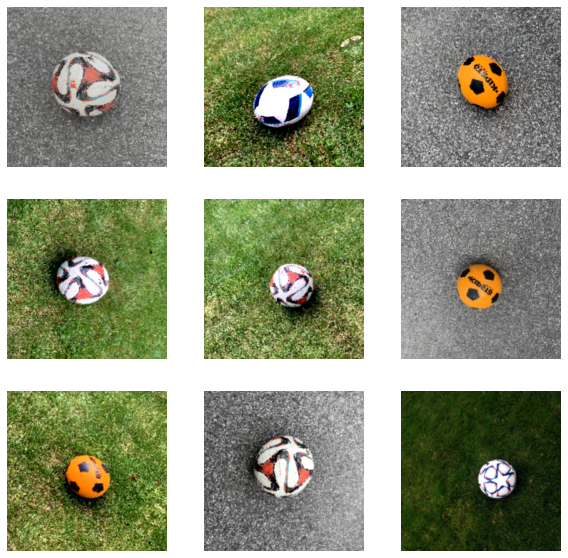

In [11]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis("off")

#printImages(train_df.sample(frac=1).head(9).iterrows())

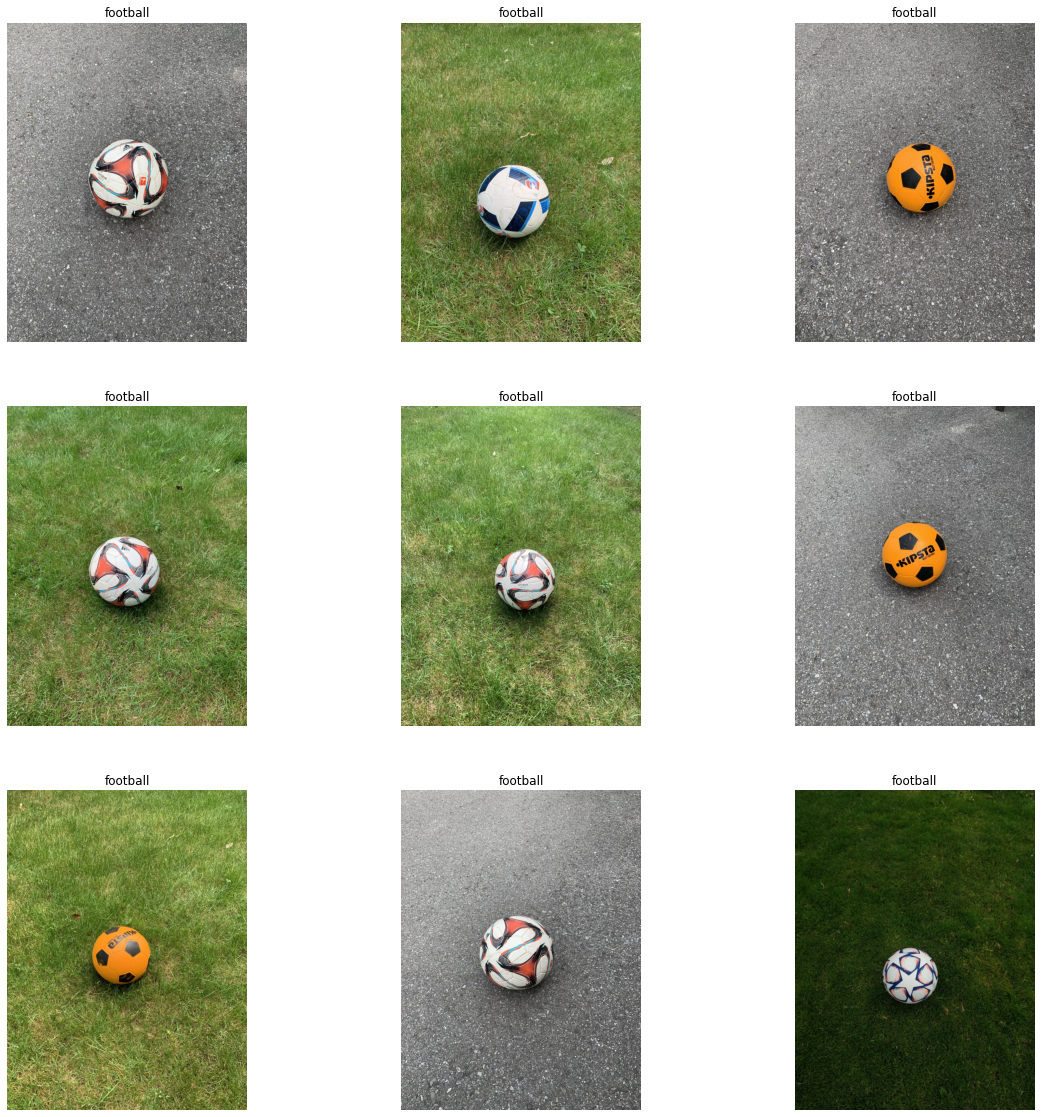

In [12]:
# Images de base
plt.figure(figsize=(20, 20))

i = 0
for _, rowdata in train_df.head(9).iterrows():
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(PIL.Image.open(rowdata.path))
    plt.title(rowdata.label)
    plt.axis("off")
    i += 1

**TODO**: plot examples of preprocessed and augmented images

## Define model

In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    Dense,
    Dropout
)

def get_model():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )
    
    layers = base_model.output
    nbLayers = len(base_model.layers)

    added_layers = [
        # important, we need global average pooling instead of flatten for class activation map later on 
        GlobalAveragePooling2D(),
        # TODO: ...
        Dense(250, activation='relu'),
        Dense(NB_CLASSES, activation='softmax')
    ]

    model = Model(inputs=base_model.input, outputs=Sequential(added_layers)(layers))

    # TODO: freeze layers
    for layer in model.layers[:nbLayers - 1]:
        layer.trainable=False
    
    model.compile(
      optimizer = RMSprop(),
      loss = SparseCategoricalCrossentropy(),
      metrics = ['acc']
    )
        
    return model

In [14]:
get_model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

# Model training

**TODO**: cross-validate your model, you can base yourself on the code from the first part of this practical work

**NOTE**: you shouldn't augment validations images. What we want to evaluate is the performances on "real" images, not on images that are augmented and change all the time 

In [16]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

shuffled_dataset = dataframe.sample(frac=1, random_state=1234).reset_index(drop=True)

dataset_paths = shuffled_dataset['path'].to_numpy()
dataset_labels = shuffled_dataset['label'].to_numpy()

total_train_paths, test_paths, total_train_labels, test_labels = train_test_split(
    dataset_paths, dataset_labels, test_size=0.2, random_state=1234
)

# We need to convert from string labels to integers
label_encoder = LabelEncoder()
label_encoder.fit(dataset_labels)
total_train_labels = label_encoder.transform(total_train_labels)
test_labels = label_encoder.transform(test_labels)

NB_EPOCHS = 4

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for train_index, val_index in KFold(n_splits=5).split(total_train_paths, total_train_labels):
    train_images = open_images(total_train_paths[train_index])    
    train_labels = total_train_labels[train_index]
    
    val_images = open_images(total_train_paths[val_index])
    val_labels = total_train_labels[val_index]
    
    model = get_model() # We reinitialize the model
    
    history = model.fit(
        x=train_images,
        y=train_labels,
        batch_size=32,
        validation_data=[val_images, val_labels],
        epochs=NB_EPOCHS,
    )
    
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['acc'])
    val_accuracies.append(history.history['val_acc'])

NameError: name 'dataframe' is not defined

In [17]:
def plot_kfold_mean_performance(ax, train_performances, val_performances, measure_name):
    train_mean = np.mean(train_performances, axis=0)
    val_mean = np.mean(val_performances, axis=0)
    train_sd = np.std(train_performances, axis=0)
    val_sd = np.std(val_performances, axis=0)
    
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean+train_sd, facecolor='blue', alpha=0.5, label='Train')
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean-train_sd, facecolor='blue', alpha=0.5)

    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean+val_sd, facecolor='orange', alpha=0.5, label='Val')
    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean-val_sd, facecolor='orange', alpha=0.5)

    ax.set_xticks(np.arange(NB_EPOCHS))

    ax.set_ylabel(measure_name)
    ax.set_xlabel('Number of epochs')
    #pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    ax.legend()
    ax.grid()

NameError: name 'train_losses' is not defined

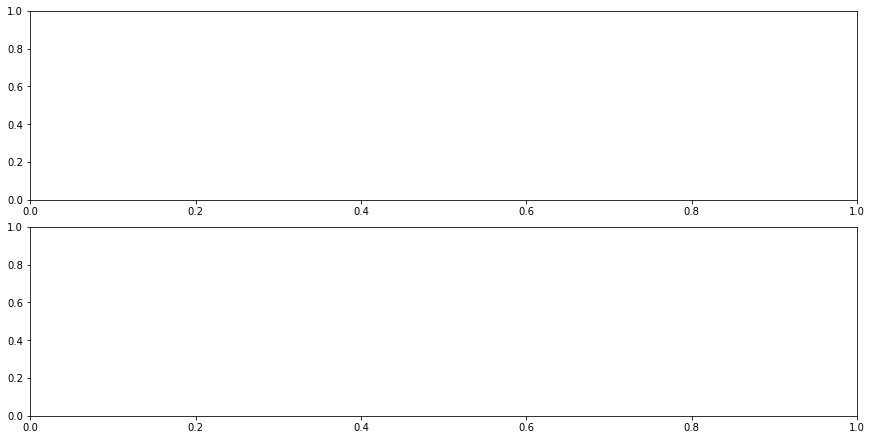

In [18]:
import matplotlib.pyplot as pl

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(12,6))

plot_kfold_mean_performance(axs[0], train_losses, val_losses, "Loss")
plot_kfold_mean_performance(axs[1], train_accuracies, val_accuracies, "Accuracy")

print(f'Train Loss function: {np.mean(np.array(train_losses)[:, -1])}')
print(f'Train Accuracy: {np.mean(np.array(train_accuracies)[:, -1])}')
print('-----------------------------------------')
print(f'Val Loss function: {np.mean(np.array(val_losses)[:, -1])}')
print(f'Val Accuracy: {np.mean(np.array(val_accuracies)[:, -1])}')

# Results

**TODO**: plot the results from your crossvalidation

## Evaluate model on test set

**TODO**: when you've selected a final model, evaluate its performances (f-score, confusion matrix, ...) on your test set

### Display some misclassified images

**TODO**: display some misclassified images to be able to see what images are difficult for the model

## Use grad-cam to inspect how the model classify
Here we can see an heatmap of the regions that activates the model the most.

### For more information:
- tf-keras-vis documentation: https://keisen.github.io/tf-keras-vis-docs/
- Grad-cam paper: https://arxiv.org/pdf/1610.02391.pdf
- Grad-cam++ paper: https://arxiv.org/pdf/1710.11063.pdf

**NOTE**: maybe you will need to adapt some variable names based on your code above. For example, _model_ should be the model trained on all the training data. 

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tensorflow.keras.applications import MobileNetV2
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Create GradCAM++ object
gradcam = GradcamPlusPlus(
    model,
    model_modifier=ReplaceToLinear(),
    clone=True,
)

nb_images_per_class = 10

fig, axs = plt.subplots(nb_images_per_class, len(LABEL_NAMES), figsize=(len(LABEL_NAMES) * 5, nb_images_per_class * 5))

for label_idx, label_name in enumerate(LABEL_NAMES):
    axs[0,label_idx].set_title(label_name, loc='center', y=1.1)
    
    i = 0
    for _, rowdata in train_df[train_df['label'] == label_name].sample(frac=1).head(nb_images_per_class).iterrows():
        img = open_image(rowdata.path)    
        pred = model(np.expand_dims(img, axis=0))

        # Generate cam with GradCAM++
        score = CategoricalScore(np.argmax(pred))
        cam = gradcam(score, img)
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

        axs[i,label_idx].imshow(img, vmin=0, vmax=1)
        axs[i,label_idx].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
        axs[i,label_idx].axis("off")

        i += 1

### Grad-cam on misclassified images

**TODO**: now do the same than above, but with the misclassified images. You shouldn't change anything pertaining to grad-cam besides on which image and prediction you do it

**TODO**: try to determine what caused the misclassifcations and what you can do about it